In [ ]:
from pathlib import Path
APP = "/app" if Path("/app").exists() else "../app"
DATA = "/data" if Path("/data").exists() else "../data"
MODEL = "/model" if Path("/model").exists() else "../model"
RUNS = "/runs" if Path("/runs").exists() else "../runs"
(APP, DATA, RUNS)

In [ ]:
import sys

app = APP
if app not in sys.path:
    sys.path.append(app)
sys.path

In [ ]:
!pwd

In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    "text",
    data_dir=f"{DATA}/text/emboj_abstracts/",
    data_files={'train': 'train/examples.txt', 'test': 'test/examples.txt'},
)
dataset

In [ ]:
MODEL_NAME = "roberta-base"

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"tokenizer vocab size: {tokenizer.vocab_size}")
print(f"max length: {tokenizer.max_model_input_sizes[MODEL_NAME]}")

In [ ]:
MAX_LENGTH_HERE = 32

In [ ]:
# tokenize the dataset
def tokenization(examples):
    return tokenizer(
    examples["text"],
        max_length=MAX_LENGTH_HERE, #tokenizer.max_model_input_sizes[MODEL_NAME],
        truncation=True,
        return_special_tokens_mask=True,
    )
tokenized = dataset.map(tokenization, batched=True)
tokenized

In [ ]:
tokenized = tokenized.remove_columns(["text"])
tokenized

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [ ]:
from transformers import (
    # RobertaForMaskedLM,
    AutoConfig
)
from src.models.modeling_dendroberta import RobertaForMaskedLM as DendroRobertaForMaskedLM

In [ ]:
config = AutoConfig.from_pretrained(MODEL_NAME)
config

In [ ]:
# mini roberta
config.num_hidden_layers = 2
config.intermediate_size = 100
config.num_attention_heads = 2
config.max_position_embeddings = MAX_LENGTH_HERE + 2

In [ ]:
model = DendroRobertaForMaskedLM(config=config)  # DendroRobertaForMaskedLM(config=config)  # RobertaForMaskedLM(config=config)
ROBERTA = "dendroberta"
model_size = sum(t.numel() for t in model.parameters())
print(f"Model size: {model_size/1000**2:.1f}M parameters")

In [ ]:
from transformers import Trainer, TrainingArguments
from datetime import datetime

args = TrainingArguments(
    output_dir=MODEL,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    evaluation_strategy="steps",
    eval_steps=100,
    prediction_loss_only=True,
    logging_steps=1000,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=False,
    push_to_hub=False,
    logging_dir = f"{RUNS}/lm-{ROBERTA}-{datetime.now().isoformat().replace(':','-')}"
)

In [ ]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized['train'],
    eval_dataset=tokenized["test"],
)

In [ ]:
trainer.train()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# launch tensorboard
%tensorboard --logdir /runs

DendRoberta: red, Robdert: blue

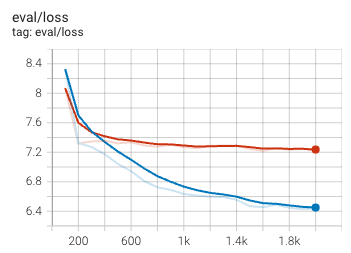